In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
train = pd.read_csv('../data/public_train/train_data.csv')

In [3]:
train.head()

,id,image_id,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,Others,dialog,narration,text,text_clean,emotion_list
0,575.0,1308_48_2,1,0,0,1,0,0,0,0,['wait a minute im not going to hurt you !'],[],['wait a minute im not going to hurt you !'],['wait a minute i am not going to hurt you !'],"['Angry', 'Happy']"
1,5395.0,3766_29_2,0,1,0,1,0,0,1,0,"[' hear that trody ? they meed a nsw carew maan , looks like were / n rusk . come on .']",[],"[' hear that trody ? they meed a nsw carew maan , looks like were / n rusk . come on .']","['he thought they need a new careman , looks like we/n rush .com on .']","['Disgust', 'Happy', 'Neutral']"
2,2004.0,2112_17_7,1,1,0,0,0,0,0,0,"['the comet leaps into action his bouyancy allows him to bounce around the office like a rubber ball', ' well , i moved ']",['the comet leaps into action his bouyancy allows him to bounce around the office like a rubber ball'],"['the comet leaps into action his bouyancy allows him to bounce around the office like a rubber ball', ' well , i moved ', 'the comet leaps into action his bouyancy allows him to bounce around the office like a rubber ball']","['the comet leaps into action , his bouyancy allows him to bounce around the office like a rubber ball .', 'well , i moved .', 'the comet leaps into action , his bouyancy allows him to bounce around the office like a rubber ball .']","['Angry', 'Disgust']"
3,4863.0,3458_16_7,0,0,0,0,0,0,1,0,"['its in there . isnt mate ?', ""yeah - t ' s in there .""]",[],"['its in there . isnt mate ?', ""yeah - t ' s in there .""]","['is it there .is not mate?', 'yeah t is in there .']",['Neutral']
4,5146.0,2338_19_3,0,0,1,0,0,1,1,0,"['listen und pass der yord along . bzzzz21', 'vot ?']",[],"['listen und pass der yord along . bzzzz21', 'vot ?']","['listen and pass your way . bzzzz21 .', 'vot?']","['Fear', 'Surprise', 'Neutral']"


In [4]:
len(train)

4365

In [5]:
train.id.nunique()

4365

In [6]:
train.image_id.nunique()

4365

In [7]:
train = train[['image_id','text_clean','emotion_list']]

In [8]:
lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

       word  count
17        ,   4618
36      the   3738
24      .']   2869
58        .   2583
40      .',   2320
...     ...    ...
28     into    131
509    over    130
432   those    127
1180    she    126
238   could    125

[100 rows x 2 columns]


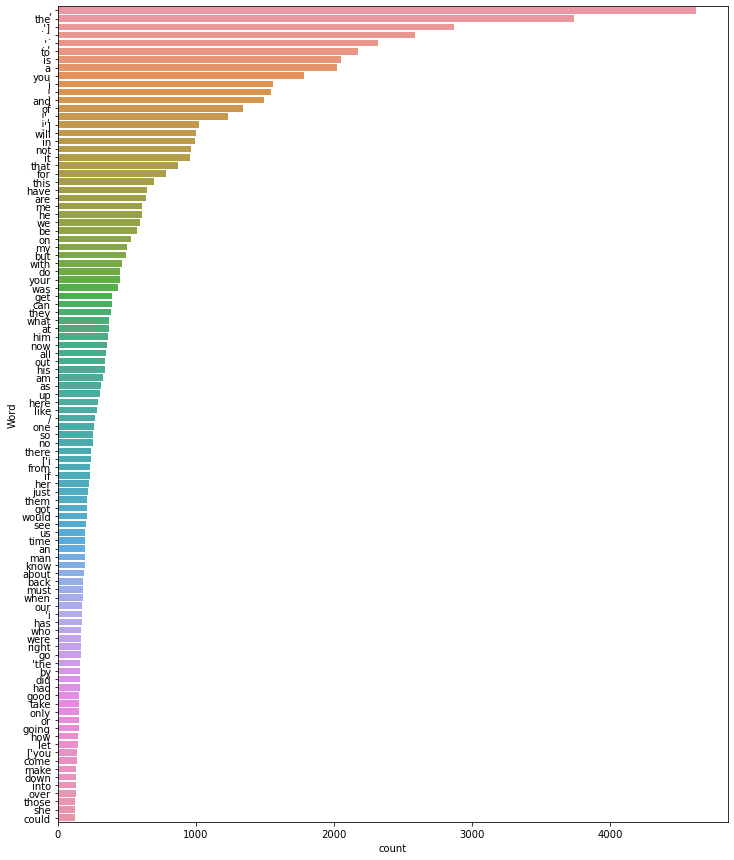

In [9]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  print(d)
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(train['text_clean'], 100)

In [10]:
import ast

In [11]:
train['emotion_list'] = train['emotion_list'].apply(lambda x: ast.literal_eval(x))

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train['emotion_list'])

# transform target variable
y = multilabel_binarizer.transform(train['emotion_list'])

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)

In [14]:
xtrain, xval, ytrain, yval = train_test_split(train['text_clean'], y, test_size=0.2, random_state=9)

In [15]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [16]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score, roc_auc_score

In [17]:
LogisticRegression?

In [18]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [19]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/home/shwetkm/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [20]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [21]:
y_pred[3]

array([0, 0, 0, 1, 1, 0, 0, 0])

In [22]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Happy', 'Neutral')

In [23]:
# evaluate performance
f1_score(yval, y_pred, average="macro")

/home/shwetkm/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2774291728674037

In [24]:
roc_auc_score(ytrain, clf.predict(xtrain_tfidf), average="macro")

0.6058517762098331

In [25]:
# evaluate performance
roc_auc_score(yval, y_pred, average="macro")

0.528448275328883

In [52]:
def infer_tags(q):
#     q = clean_text(q)
#     q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [54]:
def infer_proba(q):
#     q = clean_text(q)
#     q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
#     q_pred = clf.predict(q_vec)
    proba = clf.predict_proba(q_vec)
    return proba

In [53]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Text: ", train['text_clean'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",train['emotion_list'][k], "\n")


[[0.29940578 0.57944372 0.22583595 0.34956376 0.8000717  0.09712847
  0.19873859 0.30580167]]
Movie:  ['and besides , it ai not nice to go your nose in other people is business now beat it   .', 'guess i had not thought of it that way   .   . please excuse me   .'] 
Predicted genre:  [('Disgust', 'Neutral')]
Actual genre:  ['Fear', 'Neutral'] 

[[0.33972112 0.27501626 0.32605651 0.31393306 0.72905404 0.08339612
  0.13642514 0.56718504]]
Movie:  ['give the motor the gun   . if we have to drag it a couple of hours , we should get started   .'] 
Predicted genre:  [('Neutral', 'Surprise')]
Actual genre:  ['Angry', 'Sad', 'Surprise', 'Neutral'] 

[[0.55026599 0.33355744 0.24439803 0.52080459 0.64585109 0.04552795
  0.1548912  0.33299019]]
Movie:  ['explain / to see for yourself   . ll use taye proctor ,', 'and i wouldr my own call , but go ahead doc 7 / 7 so very myself   .'] 
Predicted genre:  [('Angry', 'Happy', 'Neutral')]
Actual genre:  ['Angry', 'Disgust', 'Happy', 'Neutral'] 

[[0.283

## Final test data

In [28]:
test = pd.read_csv('../data/public_train/test_data.csv')

In [29]:
test.head()

,id,image_id,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,Others,dialog,narration,text,text_clean,emotion_list
0,4184.0,3812_3_3,1,1,1,0,0,0,1,0,['or this what kind of reputation are these pictures giving me ?'],"[""tha day prog ahranean the recovery ou thats is each at third kin w call cla tag hour tidy en - ete . near the day ' s high dusuala trerage"", 'ats that ha nd metal', 'candidate homer bright candi right a cone and friends llai']","['or this what kind of reputation are these pictures giving me ?', ""tha day prog ahranean the recovery ou thats is each at third kin w call cla tag hour tidy en - ete . near the day ' s high dusuala trerage"", 'ats that ha nd metal', 'candidate homer bright candi right a cone and friends llai']","['or this what kind of reputation are these pictures giving me?', 'the day prog ahranean the recovery and that is each at third kin w call cla tag hour tidy in late . near the day is high monthly threshold .', 'at that hand metal .', 'candidate homer , bright candi , right , a cone and fri...","['Angry', 'Disgust', 'Fear', 'Neutral']"
1,132.0,1088_28_3,1,0,1,0,0,0,1,0,"[""he ' s not telling all he knows do you think he killed bugs"", "" i think he ' s trying to cover for someone elge tim , i think we ought to go to bug sy ' s bar as the black terrors ""]",[],"[""he ' s not telling all he knows do you think he killed bugs"", "" i think he ' s trying to cover for someone elge tim , i think we ought to go to bug sy ' s bar as the black terrors ""]","['he is not telling all he knows , do you think he killed bugs?', 'i think he is trying to cover for someone else time , i think we ought to go to bug sy is bar as the black terrors .']","['Angry', 'Fear', 'Neutral']"
2,3543.0,479_14_0,1,0,0,0,0,0,1,0,"[""you big stupid why don ' t you watch where you go !""]",[],"[""you big stupid why don ' t you watch where you go !""]",['you big stupid why do not you watch where you go !'],"['Angry', 'Neutral']"
3,4692.0,859_24_1,1,1,1,0,0,1,1,0,"[""fight it out with him it ' s the gallows if he gits us !"", "" blast em , bob ! it ' s good for you and good for my business !"", 'and goo for the communit']",[],"[""fight it out with him it ' s the gallows if he gits us !"", "" blast em , bob ! it ' s good for you and good for my business !"", 'and goo for the communit']","['fight it out with him it is the gallows if he gets us !', ""blow'em , bob ! it is good for you and good for my business !"", 'and good for the community .']","['Angry', 'Disgust', 'Fear', 'Surprise', 'Neutral']"
4,4762.0,2260_47_8,0,0,1,1,0,0,1,0,['this way to the roof'],['the fleeing boxer and photographer'],"['this way to the roof', 'the fleeing boxer and photographer']","['this way to the roof .', 'the fleeing boxer and photographer .']","['Fear', 'Happy', 'Neutral']"


In [30]:
test = test[['image_id','text_clean','emotion_list']]

In [31]:
test['emotion_list'] = test['emotion_list'].apply(lambda x: ast.literal_eval(x))

In [32]:
xtest_tfidf = tfidf_vectorizer.transform(test['text_clean'])

In [33]:
y_test = multilabel_binarizer.transform(test['emotion_list'])

In [34]:
# evaluate performance
roc_auc_score(y_test, clf.predict(xtest_tfidf), average="macro")

0.5294426932274485

In [35]:
for i in range(5): 
  k = test.sample(1).index[0] 
  print("Text: ", test['text_clean'][k], "\nPredicted genre: ", infer_tags(test['text_clean'][k])), print("Actual genre: ",test['emotion_list'][k], "\n")

Movie:  ['my fiance darcy   !'] 
Predicted genre:  [('Angry', 'Fear')]
Actual genre:  ['Fear', 'Neutral', 'Others'] 

Movie:  ['up boy , you can make ml   .'] 
Predicted genre:  [('Happy', 'Neutral')]
Actual genre:  ['Angry', 'Fear', 'Neutral'] 

Movie:  ['look out , you crazy kid what are you trying to do?'] 
Predicted genre:  [('Angry', 'Neutral')]
Actual genre:  ['Angry', 'Disgust', 'Neutral'] 

Movie:  ['what did you and the inspector find out about daddy is death?', 'i hate to tell you , dolly , but i figure that crab was responsible for his murder   .'] 
Predicted genre:  [('Angry', 'Neutral')]
Actual genre:  ['Angry', 'Surprise', 'Neutral'] 

Movie:  ['there you are   .'] 
Predicted genre:  [('Angry', 'Neutral')]
Actual genre:  ['Happy', 'Surprise'] 



In [36]:
# test['pred_tfidf_baseline'] = test['text_clean'].apply(lambda x: [y for y in infer_tags(x)[0]])

In [37]:
# test[['image_id','pred_tfidf_baseline']].to_csv('../data/public_train/predictions/tfidf_baseline_53.csv',index=None)

## Public Test

In [61]:
public_test = pd.read_csv('../data/public_train/public_test_dataset.csv')

In [62]:
public_test.head()

,dialog,narration,image_id,text,text_clean
0,"[""that ' s just the begin - ning ? ive even bigger jobs planned ha ha well make the police dance to the minstrel ' s tunes !""]",[],1000_4_6,"[""that ' s just the begin - ning ? ive even bigger jobs planned ha ha well make the police dance to the minstrel ' s tunes !""]",['that is just the beginning live even bigger jobs planned he will make the police dance to the minstrel is tunes !']
1,['cant you imagine beethoven sitting alone in his study suddenly inspiration seizes him he starts writing down these immortal notes and'],['plink - a plunk ! plunk - a - pling ! an'],1000_5_1,"['cant you imagine beethoven sitting alone in his study suddenly inspiration seizes him he starts writing down these immortal notes and', 'plink - a plunk ! plunk - a - pling ! an']","['ca not you imagine beethoven sitting alone in his study , suddenly inspiration seizes him , he starts writing down these immortal notes and?', 'kick a plunk ! plunk a pling !']"
2,"['it is your loveliness that jeb rivers remembered when he scorned me ! ill avenge myself on both of you !', ' s later , rala before we attack the boat , usher these guests into our dwelling !']",[],1003_33_2,"['it is your loveliness that jeb rivers remembered when he scorned me ! ill avenge myself on both of you !', ' s later , rala before we attack the boat , usher these guests into our dwelling !']","['it is your loveliness that jeff rivers remembered when he scorned me will avenge myself on both of you !', 'soon , rala before we attack the boat , usher these guests into our dwelling !']"
3,"[""some men are approaching ! i ' ll alert the others in case there is trouble !""]",[],1004_29_6,"[""some men are approaching ! i ' ll alert the others in case there is trouble !""]",['some men are approaching ! i will alert the others in case there is trouble !']
4,"[' a toy plane itis trying to kill me ,', ' ha , ha , ha !']",[],1009_14_1,"[' a toy plane itis trying to kill me ,', ' ha , ha , ha !']","['a toy plane is trying to kill me ,', 'ha , ha , ha !']"


In [63]:
public_test = public_test[['image_id','text_clean']]

In [64]:
xpublic_test_tfidf = tfidf_vectorizer.transform(public_test['text_clean'])

In [65]:
for i in range(5): 
  k = public_test.sample(1).index[0] 
  print("Text: ", public_test['text_clean'][k], "\nPredicted genre: ", infer_tags(public_test['text_clean'][k])), 

[[0.42098436 0.27151066 0.35814031 0.46643366 0.60576942 0.0648216
  0.12892098 0.38787104]]
Movie:  ['wa .'] 
Predicted genre:  [('Neutral',)]
[[0.34086126 0.44745272 0.36409103 0.48924179 0.67496938 0.11549298
  0.112453   0.30708983]]
Movie:  ['instant , the yellow beam from the head is too hazy to be alive man !', 'for a fleeting moment , the yellow beam from the headlights picks out porn . . . . too hazy to be alive too sinister to be human !'] 
Predicted genre:  [('Neutral',)]
[[0.40272374 0.50439239 0.34702163 0.21321824 0.71774648 0.05408249
  0.18685373 0.30659624]]
Movie:  ['the woman is dead , but he is still alive . he will not last the night though !', 'this does not look like any accident . it is about time something was done about some of these outrages everybody knows whose behind them !'] 
Predicted genre:  [('Disgust', 'Neutral')]
[[0.34037188 0.27562746 0.31036627 0.57830876 0.67646954 0.04974989
  0.09195854 0.23280085]]
Movie:  ['and this wonderful little i girl th

In [66]:
public_test['pred_tfidf_baseline'] = public_test['text_clean'].apply(lambda x: infer_proba(x)[0])

In [67]:
# public_test[['image_id','pred_tfidf_baseline']].to_csv('../data/public_train/predictions/tfidf_baseline_53.csv',index=None)

In [68]:
public_test = public_test.reset_index()

In [69]:
public_test

,index,image_id,text_clean,pred_tfidf_baseline
0,0,1000_4_6,['that is just the beginning live even bigger jobs planned he will make the police dance to the minstrel is tunes !'],"[0.5232076336872775, 0.4474371394569467, 0.2904472418335393, 0.18455649156692805, 0.8852078926375146, 0.06609051681404077, 0.10961309143180499, 0.3716513759761132]"
1,1,1000_5_1,"['ca not you imagine beethoven sitting alone in his study , suddenly inspiration seizes him , he starts writing down these immortal notes and?', 'kick a plunk ! plunk a pling !']","[0.6345605197187143, 0.5195463186661569, 0.25701380021076176, 0.14812539366201463, 0.5940830906645916, 0.02235699051506261, 0.16488749867642832, 0.4525090295311405]"
2,2,1003_33_2,"['it is your loveliness that jeff rivers remembered when he scorned me will avenge myself on both of you !', 'soon , rala before we attack the boat , usher these guests into our dwelling !']","[0.4254331093660046, 0.4379727398727669, 0.30728339352928824, 0.365317697694982, 0.7877545588301713, 0.03496147345936354, 0.25398244318243707, 0.2471115605340089]"
3,3,1004_29_6,['some men are approaching ! i will alert the others in case there is trouble !'],"[0.2697184460773953, 0.5452218405575705, 0.48681389560367994, 0.28229213216761967, 0.7687134415009755, 0.06370432553031, 0.09239908659543682, 0.4774605566138894]"
4,4,1009_14_1,"['a toy plane is trying to kill me ,', 'ha , ha , ha !']","[0.2918660186544512, 0.22272032842123557, 0.2340670574325, 0.39671882584786117, 0.6519121926586676, 0.07289850996645719, 0.18517653515119567, 0.1915912360199454]"
...,...,...,...,...
2041,2041,632_53_5,"['not so fast , punk .', 'rusmy overtakes the train .']","[0.4857993665854372, 0.24918763566392216, 0.4077596155521674, 0.4635943495218833, 0.7429812803273919, 0.05582298216477069, 0.12122381137114772, 0.4289816878151035]"
2042,2042,2302_42_3,"['the car to be the end of the gate .what back the i wonder seems walk?', 'do not know nor care let is go back .']","[0.3127814635773808, 0.24604888747247236, 0.3113831125288106, 0.4581654450432956, 0.846120144070497, 0.08644376641094129, 0.17325954352173176, 0.34093460649199236]"
2043,2043,2958_21_7,['another strip like this should do it !'],"[0.5352387898710971, 0.42908823335208446, 0.2911753466404548, 0.3658892691055771, 0.5807774522179758, 0.03720235526197181, 0.22155271267493398, 0.46471931415472895]"
2044,2044,3182_52_2,"['you shall be queen of lone canyon beautiful one !', 'order the stone man .']","[0.4798655686304346, 0.5436945022783335, 0.41724219325904055, 0.4626584722990834, 0.3928723911652177, 0.04774002548570261, 0.08788389702042247, 0.23760741678561725]"


In [70]:
emotion_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Others', 'Sad',
       'Surprise']

In [80]:
emotion_pred = pd.DataFrame(list(public_test.pred_tfidf_baseline.apply(lambda x: {emotion:y for emotion,y in zip(emotion_list,x)}).values))

In [83]:
emotion_pred = emotion_pred[['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral','Others']]

In [84]:
emotion_pred['id'] = public_test['index']

/home/shwetkm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
emotion_pred['image_id'] = public_test['image_id']

/home/shwetkm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
emotion_pred = emotion_pred[['id', 'image_id','Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral',
       'Others']]

In [96]:
len(emotion_pred)

2046

In [95]:
emotion_pred.to_csv('../data/public_train/submissions/tfidf_baseline_submission.csv',index=None,header=None)